In [572]:
import os
os.environ['OMP_NUM_THREADS'] = '3'

In [573]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [574]:
df = pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')

In [575]:
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [576]:
customer_orders = df.groupby('Customer ID', as_index=False)['Order ID'].count()
customer_sales = df.groupby('Customer ID', as_index=False)['Sales'].sum()
customer_last_order = df.groupby('Customer ID', as_index=False)['Order Date'].max()
customer_last_order['Recency'] =  (df['Order Date'].max() - customer_last_order['Order Date']).dt.days

In [577]:
kdf = pd.merge(customer_orders, customer_sales, on='Customer ID')
kdf = pd.merge(kdf, customer_last_order, on='Customer ID').drop('Order Date', axis=1)
kdf.rename(columns={'Order ID': 'Frequency', 'Sales': 'Amount'}, inplace=True)
kdf

,Customer ID,Frequency,Amount,Recency
0,AA-10315,11,5563.560,184
1,AA-10375,15,1056.390,19
2,AA-10480,12,1790.512,259
3,AA-10645,18,5086.935,55
4,AB-10015,6,886.156,415
...,...,...,...,...
788,XP-21865,28,2374.658,43
789,YC-21895,8,5454.350,4
790,YS-21880,12,6720.444,9
791,ZC-21910,31,8025.707,54


In [578]:
df['Delivery Time'] = (df['Ship Date'] - df['Order Date']).dt.days
product_sales = df.groupby('Product ID', as_index=False)['Sales'].sum()
product_orders = df.groupby('Product ID', as_index=False)['Quantity'].sum()
product_del_time = df.groupby('Product ID', as_index=False)['Delivery Time'].mean().round(2)

In [579]:
pdf = pd.merge(product_sales, product_orders, on='Product ID')
pdf = pd.merge(pdf, product_del_time, on='Product ID')
pdf

,Product ID,Sales,Quantity,Delivery Time
0,FUR-BO-10000112,825.174,9,2.00
1,FUR-BO-10000330,1064.624,10,1.67
2,FUR-BO-10000362,2154.348,14,4.00
3,FUR-BO-10000468,723.842,21,3.67
4,FUR-BO-10000711,851.760,12,6.50
...,...,...,...,...
1857,TEC-PH-10004912,516.530,11,3.33
1858,TEC-PH-10004922,1085.238,19,4.00
1859,TEC-PH-10004924,56.164,8,2.33
1860,TEC-PH-10004959,341.666,4,3.00


In [580]:
color = ['#ff9e03', 'g', 'b', 'r', '#ffb300']

In [581]:
sns.set_theme()
sns.set_style('darkgrid')
sns.set(rc={
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'axes.titlepad': 10,
    'xtick.labelsize': 10,
    'xtick.color': 'grey',
    'ytick.labelsize': 10,
    'ytick.color': 'grey',
    'axes.titlecolor': 'black',
    "figure.dpi":100, 
    'savefig.dpi':200,
    }) 

In [582]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

In [583]:
def filter_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = 1.5 * (q3 - q1)
    return data[(data > (q1 - iqr)) & (data < (q3 + iqr))]

In [584]:
def k_cluster_analysis(data):
    ssd = []

    range_n_clusters = np.arange(2, 10)
    max_score = 0
    optimal_n_clusters = 0
    for num_clusters in range_n_clusters:
        kmeans = KMeans(
            n_clusters=num_clusters, max_iter=50, n_init="auto", random_state=420
        )
        kmeans.fit(data)
        # Elbow-curve /SSD
        ssd.append(kmeans.inertia_)

        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        if silhouette_avg > max_score:
            max_score = silhouette_avg
            optimal_n_clusters = num_clusters
        print(
            "For n_clusters={0}, the silhouette score is {1}".format(
                num_clusters, silhouette_avg
            )
        )

    # plot the SSDs for each n_clusters
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.lineplot(ssd, ax=ax)
    return optimal_n_clusters

For n_clusters=2, the silhouette score is 0.34055717955067577
For n_clusters=3, the silhouette score is 0.363179166936144
For n_clusters=4, the silhouette score is 0.3131258069813781
For n_clusters=5, the silhouette score is 0.3335618099130335
For n_clusters=6, the silhouette score is 0.27698664587792876
For n_clusters=7, the silhouette score is 0.27283126610296354
For n_clusters=8, the silhouette score is 0.28357128970200746
For n_clusters=9, the silhouette score is 0.28763988189026635
[(0, 102), (1, 264), (2, 299)]


,Customer ID,Frequency,Amount,Recency,Cluster ID
0,AA-10315,11.0,5563.560,184.0,1
1,AA-10375,15.0,1056.390,19.0,2
2,AA-10480,12.0,1790.512,259.0,0
3,AA-10645,18.0,5086.935,55.0,1
7,AB-10150,12.0,966.710,41.0,2
...,...,...,...,...,...
784,VS-21820,8.0,1055.981,221.0,0
786,VW-21775,18.0,6134.038,28.0,1
789,YC-21895,8.0,5454.350,4.0,1
790,YS-21880,12.0,6720.444,9.0,1


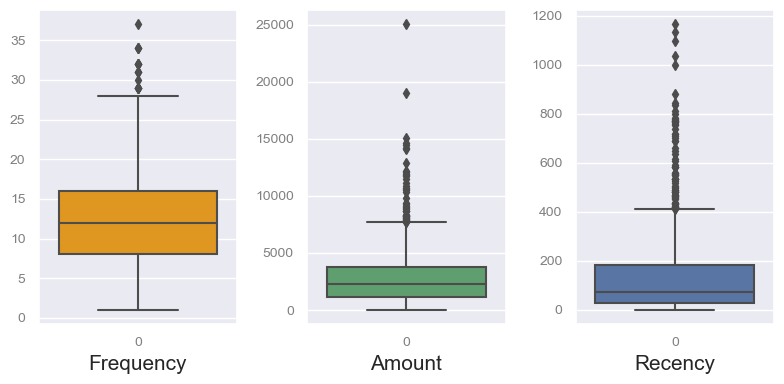

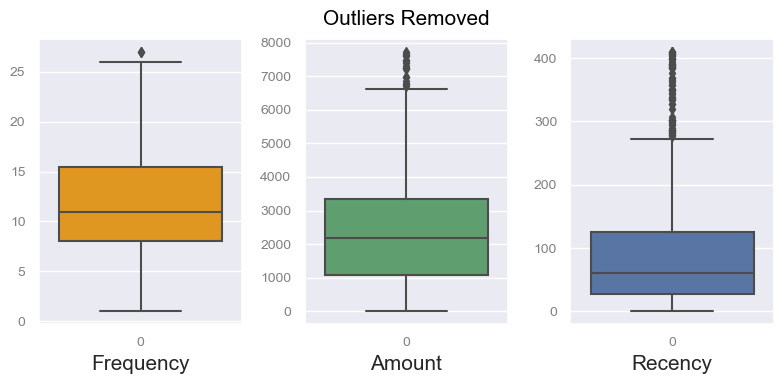

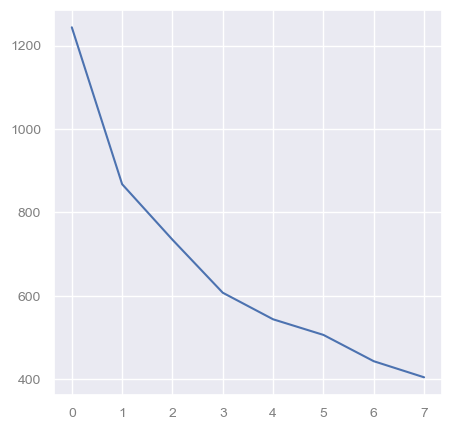

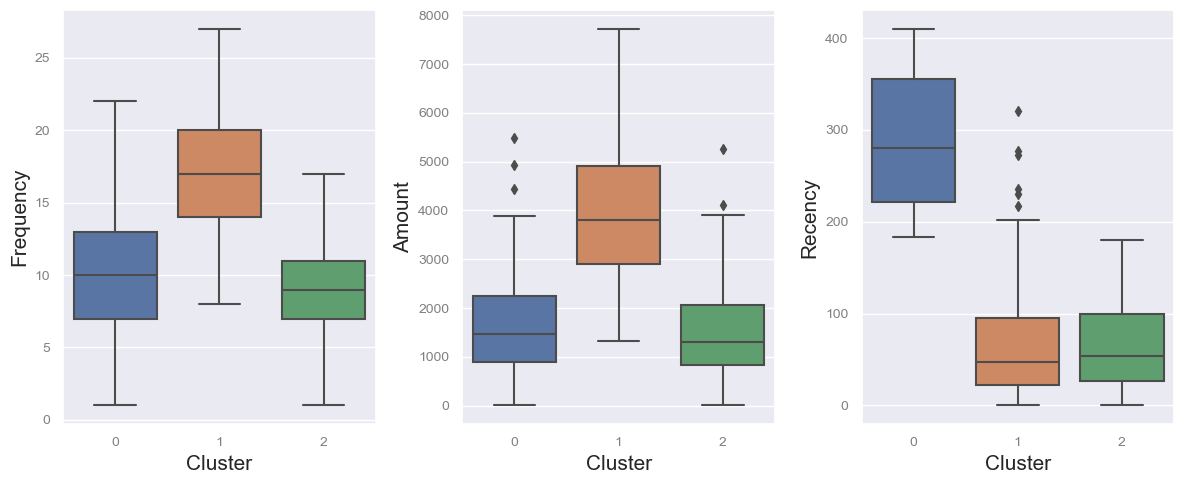

In [587]:
def k_clustering(dataframe):

    # Make a copy of a dataframe
    data = dataframe.copy()
    # Determine the number of columns in the dataframe
    b = len(data.columns[1:])
    
    # Plot the features
    fig, ax = plt.subplots(1, b, figsize=(8, 4))
    for i, col in enumerate(data.columns[1:]):
        sns.boxplot(data=data[col], ax=ax[i], color=color[i])
        ax[i].set_xlabel(col)
    plt.tight_layout()
    
    # Remove the ouliers and plot the features again        
    fig, ax = plt.subplots(1, b, figsize=(8, 4))
    for i, col in enumerate(data.columns[1:]):
        # Removing outliers
        data[col] = filter_outliers(data[col])
        sns.boxplot(data=data[col], ax=ax[i], color=color[i])
        ax[i].set_xlabel(col)
    ax[1].set_title("Outliers Removed")
    plt.tight_layout()

    # Remove the rows where ouliers were
    data.dropna(inplace=True)

    # Scale the data with StandartScaler
    scaled_data = StandardScaler().fit_transform(data[data.columns[1:]])
    scaled_data = pd.DataFrame(scaled_data)
    scaled_data.columns = data.columns[1:]

    # Initiate k-means and find the k with the highest silhouette score
    kmeans = KMeans(
        n_clusters=k_cluster_analysis(scaled_data), max_iter=50, n_init="auto"
    )
    kmeans.fit(scaled_data)

    # Assign the labels to each data point, and execute the following script.
    kmeans.labels_
    label_list = kmeans.labels_
    print(sorted(Counter(label_list).items()))

    # Assign the label
    data["Cluster ID"] = kmeans.labels_

    fig, ax = plt.subplots(1, b, figsize=(12, 5))

    for i, col in enumerate(data.columns[1:4]):
        sns.boxplot(x="Cluster ID", y=col, data=data, ax=ax[i])
        ax[i].set_xlabel("Cluster")
    plt.tight_layout()

    return data

k_clustering(kdf)

In [586]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:]):
#     sns.boxplot(data=kdf[col], ax=ax[i], color=color[i])
#     ax[i].set_xlabel(col)

# ax[1].set_title('Customer Features')


# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:]):
#     sns.boxplot(data=filter_outliers(kdf[col]), ax=ax[i], color=color[i])
#     ax[i].set_xlabel(col)

# # Removing the outliers 

# for col in kdf.columns[1:]:
#     kdf[col] = filter_outliers(kdf[col])
#     # kdf[kdf[col].isna()] = kdf[col].max()

# kdf.dropna(inplace=True)

# # Instantiate
# scaler = StandardScaler()

# # fit_transform
# scaled_kdf = scaler.fit_transform(kdf[['Amount', 'Frequency', 'Recency']])
# scaled_kdf.shape

# scaled_kdf = pd.DataFrame(scaled_kdf)
# scaled_kdf.columns = ['Amount', 'Frequency', 'Recency']
# scaled_kdf.head()

# # k-means with some arbitrary k
# kmeans = KMeans(n_clusters=4, max_iter=50, n_init='auto')
# kmeans.fit(scaled_kdf)

# # Assign the labels to each data point, and execute the following script.
# kmeans.labels_
# label_list=kmeans.labels_
# sorted(Counter(label_list).items())

# k_cluster_analysis(scaled_kdf)

# kmeans = KMeans(n_clusters=3, max_iter=50, n_init='auto')
# kmeans.fit(scaled_kdf)

# # Assign the label
# kdf['Cluster ID'] = kmeans.labels_
# kdf.head()

# fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# for i, col in enumerate(kdf.columns[1:4]):
#     sns.boxplot(x='Cluster ID', y=col, data=kdf, ax=ax[i])
#     ax[i].set_xlabel(col)
# plt.tight_layout()

# fig, ax = plt.subplots(figsize=(8, 6))
# sns.scatterplot(data=kdf, x='Recency', y='Amount', hue='Cluster ID', palette='tab10')